In [1]:
import os
os.chdir(r"C:\Users\user\DACON Dropbox\1. 대회\13th_제주테크노파크2\데이터 정제\1. 데이터\2. 최종 데이터")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1. date 변수 변환

date 컬럼을 판다스의 datetime 변수형으로 변환한다.

In [3]:
train['date2'] = pd.to_datetime(train['date'])

date 컬럼으로부터 요일을 뽑아낸다.

In [4]:
train['weekday'] = train['date2'].dt.weekday

파이썬 도큐멘테이션에는 weekday를 아래와 같이 설명하고 있다.

Return the day of the week as an integer, where Monday is 0 and Sunday is 6.

weekday 변수 생성 후 pandas의 get_dummies 함수를 활용하여 weekday에 대한 one hot encoding을 실행한다.

In [5]:
train = pd.get_dummies(train,columns=['weekday'])

test 데이터에 대해서도 위와 똑같은 변환을 해준다.

In [6]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [7]:
del train['date2']
del test['date2']

# 2. in_out 변수 변환

In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

보다시피 '시외'인 것이 매우 적다.

'시외'를 1로, '시내'를 0으로 변환한다.

In [9]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

test 데이터에 대해서도 위와 똑같은 변환을 해준다.

In [10]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 승차, 하차 시간대 통합 작업

현재 train, test data는 오전 시간대의 경우, 1시간마다의 승차, 하차 인원수를 표시해주고 있지만,

예측하려고 하는 퇴근시간대의 경우, 2시간에 해당되는 승차 인원을 예측하여야 한다.

그렇기 때문에, 오전 시간대에 승차, 하차 인원수들도 2시간 간격으로 통합해주었다

In [11]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

해당 통합 작업 이후 생성된 변수와 퇴근시간대의 승차 인원의 상관관계를 확인하기 위하여

다음의 heatmap을 생성하였다.

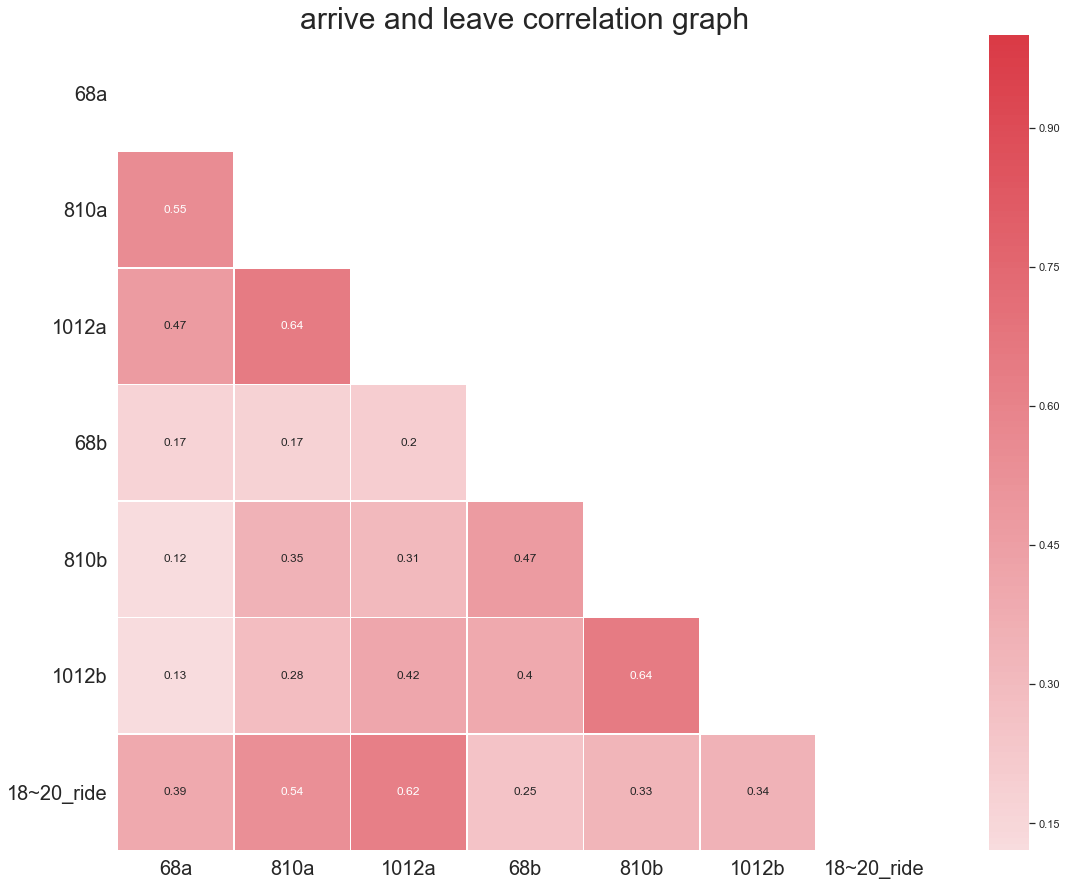

In [12]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

변수의 갯수는 줄었음에도 불구하고, 값이 통합되어 전체적인 값이 크기가 증가하였기 때문에,

목적변수와 독립변수들 간에 동일한 혹은 더 높은 상관관계를 가지고 있음을 확인할 수 있다.

(1시간 간각의 heatmap의 경우 변수만 바꿔서 넣어주면 그리기 가능)

해당 2시간 간격 통합을 test data에도 실행시켜 준다

In [13]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

# 4. 좌표 데이터를 이용한 Feature Engineering

## 4-1. 측정소 위치 및 정류장 위치 확인

제주도의 인구는 서귀포시와 제주시에 몰려 있는 경우가 많으며, 해당 지역 및 서쪽 동쪽 지역의 위치를 활용하여,

해당 지역과의 거리를 각각 feature로 추가하겠다.

<strong>제주 측정소의 위.경도</strong> : 33.51411, 126.52969

<strong>고산 측정소의 위.경도</strong> : 33.29382, 126.16283

<strong>성산 측정소의 위.경도</strong> : 33.38677, 126.880

<strong>서귀포 측정소의 위.경도</strong> : 33.24616, 126.5653

2 개의 좌표 간의 거리를 구하는 함수는 파이썬의 geopy 패키지에 존재한다.

In [14]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

현재 4개 측정소의 위치가 어느 쪽에 있는지 확인이 가능하다.

In [15]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

같은 정류장의 이름이 있는게 2개가 있는 경우, 위도 경도의 평균을 적용한 다음

시각화를 하여서 해당 정류소들의 위치를 확인한 결과는 다음과 같다.

## 4-2. 측정소와 정류장 사이 거리 계산 적용

2 개의 좌표 간의 거리를 구하는 함수는 파이썬의 geopy 패키지에 존재한다.

geopy.distance.vincenty를 이용하여, m 단위 혹은 km 단위로 계산이 가능하다.(현재 baseline은 km 단위 사용)

<strong>dis_jeju</strong> : 버스정류장과 제주 측정소와의 거리

<strong>dis_gosan</strong> : 버스정류장과 고산 측정소시와의 거리

<strong>dis_seongsan</strong> : 버스정류장과 성산 측정소와의 거리

<strong>dis_po</strong> : 버스정류장과 서귀포 측정소와의 거리

각 정류장과 제주도에 존재하는 4군데의 기상 측정소와의 거리를 계산하여 t1~t4에 할당

In [16]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

각 측정소와 정류소의 거리를 계산한 다음, 해당 정류소에서 가장 가까운 곳에 있는 측정소를 dist_name 변수의 값으로 넣는다

In [17]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({'jeju': 1479, 'po': 828, 'gosan': 659, 'seongsan': 597})

현재 전체 정류장별 어느 측정소와 가장 가까운지 Counter를 통해서 확인이 가능하다. 

test_data에도 적용

In [18]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

# 5. 외부 실제 측정 데이터 활용

해당 중급자 코드에서는 외부 데이터 중 오전시간대의 실제 측정 데이터를 활용하여서 변수로 활용하고자 한다.

외부데이터 사용 공지사항은 https://dacon.io/cpt13/257000 를 통해 확인이 가능하며,

현재 사용하는 외부데이터의 출처는 다음과 같다. https://data.kma.go.kr/cmmn/main.do

(해당 사이트에서 제주도 전체 선택 후, 사용하려는 일자, 기온, 강수량 선택)

외부데이터 사용 기간은 2019.09.01 ~ 10.16일이며 해당 데이터를 불러온 뒤, 06~11시에 해당되는 사항들만 편집하여서 사용하였기 때문에

data leakage에 해당되지 않는다.

In [19]:
#데이터 불러오기
raining=pd.read_csv(r"C:\Users\user\DACON Dropbox\1. 대회\13th_제주테크노파크2\데이터 정제\1. 데이터\3. 보조 데이터\rain.csv",engine='python')

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,jeju,2019-09-01 0:00,23.7,NaN,2.0,180.0,67,1014.0,1016.4,NaN,NaN
1,jeju,2019-09-01 1:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
2,jeju,2019-09-01 2:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
3,jeju,2019-09-01 3:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
4,jeju,2019-09-01 4:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN


data merge를 위하여, 일시와 시간대를 분리

In [20]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>=6) & (raining['time']<12)  ]

해당 시간대의 평균 기온 및 강수량을 변수로 사용할 예정이기 때문에, groupby를 실행

In [21]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

최종적으로 완성이 된 외부데이터와 현재 만들어진 train, test data에 각각 merge 한다.

In [22]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

외부데이터와 결합 이후에, 기존에 만들어 놓은, dist name 변수에 one hot encoding을 실행한다.

In [23]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

# 6. randomforest을 활용한 모델링

## 6-1. 변수 선택 및 train data sampling

sklearn 내부의 randomforest 함수를 이용해 모델링을 진행한다.

머신러닝 학습에 활용할 input 변수와 target 변수를 다음과 같이 정의한다.

input_var : (시내,시외 여부, 위도 및 경도, 오전시간대 승,하차 기록, 요일 one hot encoding, 각 측정소와 정류장 사이의 km 거리,

외부데이터 기온, 강수량,  dist_name one hot encoding)

In [25]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

현재 randomforest regressor의 최적의 parameter를 찾는 과정을 GridSearchCV를 활용하여 수행하려고 한다.

하지만, 전체 데이터를 사용하여서 최적의 paramter를 찾으려고 하는 경우, 시간이 매우 오래 걸리기 때문에

train data의 1%에 해당되는 데이터만 활용하여서 최적의 parameter 값을 찾고 이를 전체 train data에 학습시키려고 한다.

In [26]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

((4154, 26), (4154, 1))

## 6-2. GridSearCV and RandomForestRegressor

In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 2분 ~ 3분 소요

{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [28]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

((415423, 26), (415423, 1), (228170, 26))

In [31]:
# best_params_를 통해서 나온 값을 투입
rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)

rf.fit(X_train,y_train) #학습 

test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("dacon_base_middle2.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

#해당 코드 소요 시간 5분